In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[11]: [FileInfo(path='dbfs:/FileStore/tables/Dataframes_Assignment__1_.ipynb', name='Dataframes_Assignment__1_.ipynb', size=34543, modificationTime=1652224278000),
 FileInfo(path='dbfs:/FileStore/tables/New_Text_Document.txt', name='New_Text_Document.txt', size=2637452, modificationTime=1646128769000),
 FileInfo(path='dbfs:/FileStore/tables/W6S1Demo_mapreduce.ipynb', name='W6S1Demo_mapreduce.ipynb', size=12935, modificationTime=1647192093000),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1647963102000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1645626546000),
 FileInfo(path='dbfs:/FileStore/tables/character_counting-1.ipynb', name='character_counting-1.ipynb', size=25386, modificationTime=1645912625000),
 FileInfo(path='dbfs:/FileStore/tables/character_counti

In [0]:
#filepath stored in filepath variable
filepath = "/FileStore/tables/clinicaltrial_2021_csv.gz"

In [0]:
# file copied from the filepath to tmp
dbutils.fs.cp(filepath,"file:/tmp/")

Out[13]: True

In [0]:
%sh
gzip -d /tmp/ /tmp/clinicaltrial_2021_csv.gz

gzip: /tmp/ is a directory -- ignored


In [0]:
# file moved to specific directory
dbutils.fs.mv("file:/tmp/clinicaltrial_2021_csv","/FileStore/tables/")

Out[15]: True

In [0]:
# prepared to the required csv format
dbutils.fs.mv("/FileStore/tables/clinicaltrial_2021_csv","/FileStore/tables/clinicaltrial_2021.csv")

Out[16]: True

In [0]:
# reading the csv file which has seperator = |
clinicaltrial_2021 = spark.read.option("header","true").csv("/FileStore/tables/clinicaltrial_2021.csv", sep="|")

In [0]:
#Question 1
clinicaltrial_2021.distinct().count()

Out[18]: 387261

In [0]:
#Question 2
clinical_trial= clinicaltrial_2021.groupBy('Type').count()
clinical_trial.orderBy('count', ascending=False).show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
#Question 3
from pyspark.sql.functions import split,explode
clinical_trial = clinicaltrial_2021.withColumn('splitconditions', split(clinicaltrial_2021.Conditions,","))
exploded_clinical_trial = clinical_trial.withColumn('explodedconditions', explode(clinical_trial.splitconditions))
exploded_clinical_trial_group=exploded_clinical_trial.groupBy("explodedconditions").count()
exploded_clinical_trial_group.orderBy('count', ascending=False).show(n=5)

+------------------+-----+
|explodedconditions|count|
+------------------+-----+
|         Carcinoma|13389|
| Diabetes Mellitus|11080|
|         Neoplasms| 9371|
|  Breast Neoplasms| 8640|
|          Syndrome| 8032|
+------------------+-----+
only showing top 5 rows



In [0]:
#Question 4
from pyspark.sql.functions import split
mesh = spark.read.option("header","true").csv("/FileStore/tables/mesh.csv")
mesh_split = split(mesh.tree, '\.')
mesh_split_code = mesh.withColumn('tree',mesh_split[0])
clinic_mesh = exploded_clinical_trial.join(mesh_split_code, exploded_clinical_trial.explodedconditions == mesh_split_code.term)
clinic_mesh.groupBy("tree").count().orderBy('count', ascending=False).show(10)

+----+------+
|tree| count|
+----+------+
| C04|143994|
| C23|136079|
| C01|106674|
| C14| 94523|
| C10| 92310|
| C06| 85646|
| C08| 70720|
| C13| 42599|
| C18| 41276|
| C12| 40161|
+----+------+
only showing top 10 rows



In [0]:
#Question 5
pharma = spark.read.option("header","true").csv("/FileStore/tables/pharma.csv")
clinical_df = clinical_trial.select(clinical_trial.Sponsor)
clinical_joineddf = clinical_df.join(pharma, clinical_df["Sponsor"] == pharma["Parent_Company"], "leftanti")
clinical_joineddf.groupby("Sponsor").count().orderBy('count', ascending=False).show(n=10)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



In [0]:
#Question 6
from pyspark.sql.functions import split
clincial_year = clinicaltrial_2021.filter("Status == 'Completed'")
clincial_split = split(clinicaltrial_2021['Completion'], ' ')
clincial_year1 = clincial_year.withColumn('Year',clincial_split[1])
clincial_year_month = clincial_year1.withColumn('Month',clincial_split[0])
clincial_year_month_group = clincial_year_month.filter("Year == 2021").groupBy('month').count()
clincial_year_month_group.orderBy('count', ascending=False).show()

+-----+-----+
|month|count|
+-----+-----+
|  Mar| 1227|
|  Jan| 1131|
|  Jun| 1094|
|  May|  984|
|  Apr|  967|
|  Feb|  934|
|  Jul|  819|
|  Aug|  700|
|  Sep|  528|
|  Oct|  187|
+-----+-----+



Out[24]: <matplotlib.legend.Legend at 0x7f59f81d7e50>

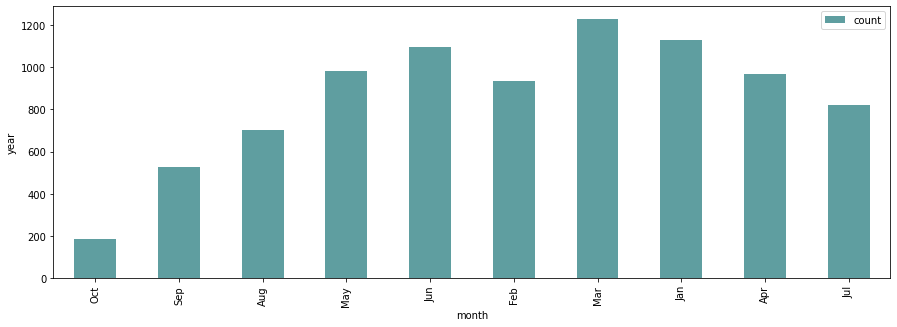

In [0]:
#visualisation in python
pandas_df = clincial_year_month_group.toPandas()
p = pandas_df.plot.bar(x='month',y='count',stacked=False, legend=False, figsize=(15,5), color='cadetblue') 
p.set_xlabel("month")
p.set_ylabel("year")
patches, labels = p.get_legend_handles_labels()
p.legend(patches, labels, loc='best')